In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
import numbers
from scipy.special import erf,erfc

/Users/JyotiSrivastava/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Function to obtain the parameters for the SELU with arbitrary fixed point (mean variance)

In [3]:
def getSeluParameters(fixedpointMean=0,fixedpointVar=1):
    """ Finding the parameters of the SELU activation function. The function returns alpha and lambda for the desired fixed point. """
    
    import sympy
    from sympy import Symbol, solve, nsolve

    aa = Symbol('aa')
    ll = Symbol('ll')
    nu = fixedpointMean 
    tau = fixedpointVar 

    mean =  0.5*ll*(nu + np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi)*np.sqrt(tau) + \
                        nu*erf(nu/(np.sqrt(2*tau))) - aa*erfc(nu/(np.sqrt(2*tau))) + \
                        np.exp(nu+tau/2)*aa*erfc((nu+tau)/(np.sqrt(2*tau))))

    var = 0.5*ll**2*(np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi*tau)*nu + (nu**2+tau)* \
                          (1+erf(nu/(np.sqrt(2*tau)))) + aa**2 *erfc(nu/(np.sqrt(2*tau))) \
                          - aa**2 * 2 *np.exp(nu+tau/2)*erfc((nu+tau)/(np.sqrt(2*tau)))+ \
                          aa**2*np.exp(2*(nu+tau))*erfc((nu+2*tau)/(np.sqrt(2*tau))) ) - mean**2

    eq1 = mean - nu
    eq2 = var - tau

    res = nsolve( (eq2, eq1), (aa,ll), (1.67,1.05))
    return float(res[0]),float(res[1])


### Adjust the SELU function and Dropout to your new parameters

In [4]:
myFixedPointMean = 0
myFixedPointVar = 1
myAlpha,myLambda = getSeluParameters(myFixedPointMean,myFixedPointVar)

In [5]:
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = myAlpha
        scale = myLambda
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

In [6]:
def relu(x):
    return tf.nn.relu(x)

## New Dropout Technique. 
- Standard dropout randomly sets an activation x to zero with probability (1 − q) for 0<q<1 . In order to preserve the mean, the activations are scaled by 1/q during training. If x has mean E(x) = µ and variance Var(x) = ν, and the dropout variable d follows a binomial distribution B(1, q), then the mean E(1/qdx) = µ is kept. Dropout fits well to rectified linear units, since zero is in the low variance region and corresponds to the default value. 
- For scaled exponential linear units, the default and low variance value is limx→−∞ selu(x) = −λα = α'
Therefore, we propose “alpha dropout”, that randomly sets inputs to α'.
- - New Mean = E(xd + α'(1 − d)) = qµ + (1 − q)α'
- - New Variance = Var(xd + α'(1 − d)) = q((1 − q)(α' −µ)^2 + ν). 
- We aim at keeping mean and variance to their original values after “alpha dropout”, in
order to ensure the self-normalizing property even for “alpha dropout”. The affine transformation
a(xd + α
0
(1 − d)) + b allows to determine parameters a and b such that mean and variance are
kept to their values: E(a(xd + α
0
(1 − d)) + b) = µ and Var(a(xd + α
0
(1 − d)) + b) = ν . In
contrast to dropout, a and b will depend on µ and ν, however our SNNs converge to activations with
zero mean and unit variance. With µ = 0 and ν = 1, we obtain 
- - a = q + α'<sup>2</sup>q(1 − q)<sup>-1/2</sup>
- - b = − (q + α'<sup>2</sup> q(1 − q))<sup>-1/2</sup>((1 − q)α').
- The parameters a and b only depend on the dropout rate 1 − q and the most negative activation α'.
- Empirically, we found that dropout rates 1 − q = 0.05 or
0.10 lead to models with good performance. “Alpha-dropout” fits well to scaled exponential linear
units by randomly setting activations to the negative saturation value.

In [7]:
def dropout_selu(x, rate, alpha= -myAlpha*myLambda, fixedPointMean=myFixedPointMean, fixedPointVar=myFixedPointVar, 
                 noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        # Calculate the probability of keeping an activation
        keep_prob = 1.0 - rate

        # Convert inputs to TensorFlow tensors
        x = ops.convert_to_tensor(x, name="x")
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")
        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")

        # If keep_prob is 1, no dropout is applied
        if tensor_util.constant_value(keep_prob) == 1:
            return x

        # Generate a random tensor and binary tensor for dropout
        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        binary_tensor = math_ops.floor(random_tensor)

        # Apply dropout with scaled values
        ret = x * binary_tensor + alpha * (1-binary_tensor)

        # Calculate scaling parameters a and b for SELU activation
        a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))
        b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
        
        # Apply rescaling to the dropout result
        ret = a * ret + b
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        # Use smart_cond to conditionally apply dropout during training
        return utils.smart_cond(training,
            lambda: dropout_selu_impl(x, rate, alpha, noise_shape, seed, name),
            lambda: array_ops.identity(x))


In [13]:

x = tf.Variable(tf.random.normal([1000], mean=myFixedPointMean, stddev=np.sqrt(myFixedPointVar)))
w = selu(x)
y = dropout_selu(w, 0.1,training=True)

print("mean/var should be at:", myFixedPointMean, "/", myFixedPointVar)
print("Input data mean/var:  ", "{:.12f}".format(np.mean(x.numpy())), "/", "{:.12f}".format(np.var(x.numpy())))    
print("After selu:           ", "{:.12f}".format(np.mean(w.numpy())), "/", "{:.12f}".format(np.var(w.numpy())))
print("After dropout mean/var", "{:.12f}".format(np.mean(y.numpy())), "/", "{:.12f}".format(np.var(y.numpy())))


mean/var should be at: 0 / 1
Input data mean/var:   -0.030395992100 / 1.005383968353
After selu:            -0.032702125609 / 1.012603759766
After dropout mean/var -0.029989460483 / 1.007659554482


In [14]:
# Loop through different dropout rates
dropout_rates = [0.05,0.1, 0.3, 0.5]

for dropout_rate in dropout_rates:
    # Apply dropout with the current rate
    y = dropout_selu(w, dropout_rate,training=True)

    print(f"Dropout Rate: {dropout_rate}")
    print("mean/var should be at:", myFixedPointMean, "/", myFixedPointVar)
    print("Input data mean/var:  ", "{:.12f}".format(np.mean(x.numpy())), "/", "{:.12f}".format(np.var(x.numpy())))    
    print("After selu:           ", "{:.12f}".format(np.mean(w.numpy())), "/", "{:.12f}".format(np.var(w.numpy())))
    print("After dropout mean/var", "{:.12f}".format(np.mean(y.numpy())), "/", "{:.12f}".format(np.var(y.numpy())))
    print("\n")

Dropout Rate: 0.05
mean/var should be at: 0 / 1
Input data mean/var:   -0.030395992100 / 1.005383968353
After selu:            -0.032702125609 / 1.012603759766
After dropout mean/var -0.013471622020 / 0.982254266739


Dropout Rate: 0.1
mean/var should be at: 0 / 1
Input data mean/var:   -0.030395992100 / 1.005383968353
After selu:            -0.032702125609 / 1.012603759766
After dropout mean/var -0.022066656500 / 0.990405976772


Dropout Rate: 0.3
mean/var should be at: 0 / 1
Input data mean/var:   -0.030395992100 / 1.005383968353
After selu:            -0.032702125609 / 1.012603759766
After dropout mean/var -0.012843501754 / 1.021294236183


Dropout Rate: 0.5
mean/var should be at: 0 / 1
Input data mean/var:   -0.030395992100 / 1.005383968353
After selu:            -0.032702125609 / 1.012603759766
After dropout mean/var -0.010300192982 / 0.962045192719




The dropout rates 0.05, 0.10 are obseerved to be optimal and hence we take dropout as 0.1

In [15]:
after_selu = []
after_selu_v = []
after_dropout = []
after_dropout_v = []
for i in range(10000):
    z=y
    w = selu(z)
    after_selu.append(np.mean(w.numpy()))
    after_selu_v.append(np.var(w.numpy()))
    y = dropout_selu(w, 0.1,training=True)
    after_dropout.append(np.mean(y.numpy()))
    after_dropout_v.append(np.var(y.numpy()))

print("mean/var should be at:", myFixedPointMean, "/", myFixedPointVar)
print("Input data mean/var:  ", "{:.12f}".format(np.mean(x.numpy())), "/", "{:.12f}".format(np.var(x.numpy())))    
print("After selu:           ", "{:.12f}".format(np.mean(w.numpy())), "/", "{:.12f}".format(np.var(w.numpy())))
print("After dropout mean/var", "{:.12f}".format(np.mean(y.numpy())), "/", "{:.12f}".format(np.var(y.numpy())))

mean/var should be at: 0 / 1
Input data mean/var:   -0.030395992100 / 1.005383968353
After selu:            -0.657882571220 / 0.598017334938
After dropout mean/var -0.546289563179 / 0.530062735081


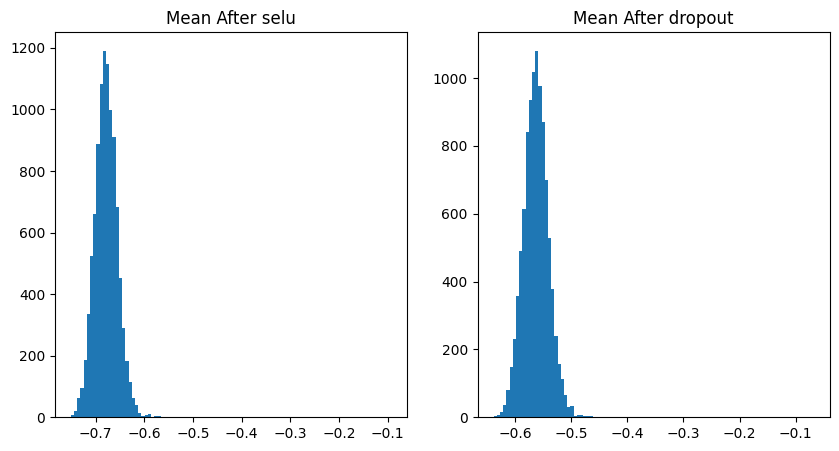

In [16]:
# plot after selu after dropout
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(after_selu,100)
plt.title("Mean After selu")
plt.subplot(1,2,2)
plt.hist(after_dropout,100)
plt.title("Mean After dropout")
plt.show()

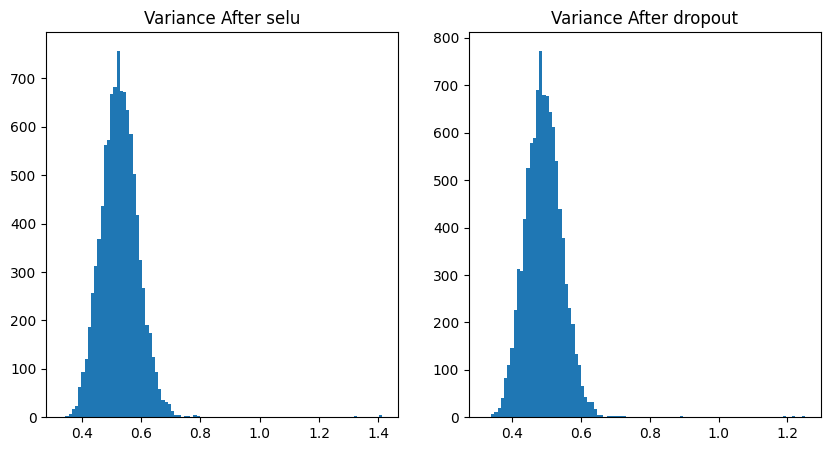

In [17]:
# plot after selu after dropout
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(after_selu_v,100)
plt.title("Variance After selu")
plt.subplot(1,2,2)
plt.hist(after_dropout_v,100)
plt.title("Variance After dropout")
plt.show()

### Plotting the SELU activation with the parameters for zero mean

In [163]:
def selu(x,mean,var):
    """SELU activation function."""
    alpha,lambda_=getSeluParameters(mean,var)
    return lambda_ * np.where(x > 0, x, alpha * (np.exp(x) - 1))

In [164]:
# helper function to plot the selu activation function
def plot_selu(mean,var):
    
    """Plot the SELU activation function."""
    x = np.linspace(-3,3,1000)
    y = selu(x,mean,var)

    # Plot the SELU activation function
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label='SELU Activation', color='blue')
    plt.title('SELU Mean: '+str(mean)+' Variance: '+str(var))
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # display alpha and lambda
    alpha,lambda_=getSeluParameters(mean,var)
    plt.text(-2.5, 0.5, r'$\alpha = %.2f$' % alpha, fontsize=14)
    plt.text(-2.5, 0.0, r'$\lambda = %.2f$' % lambda_, fontsize=14)
    
    plt.show()


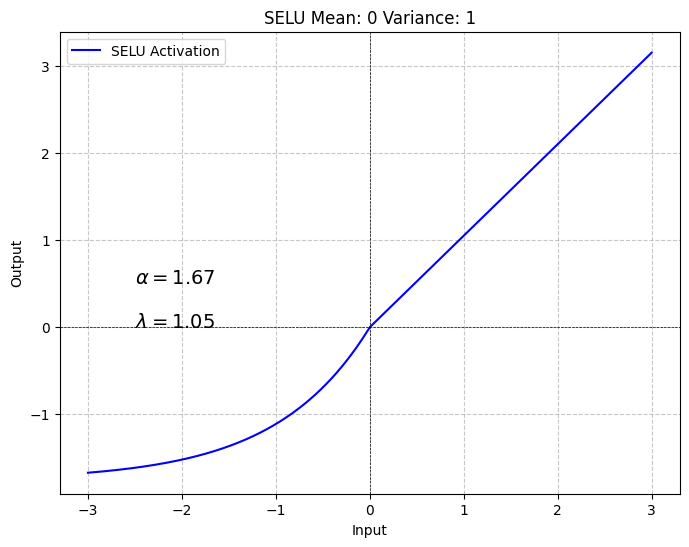

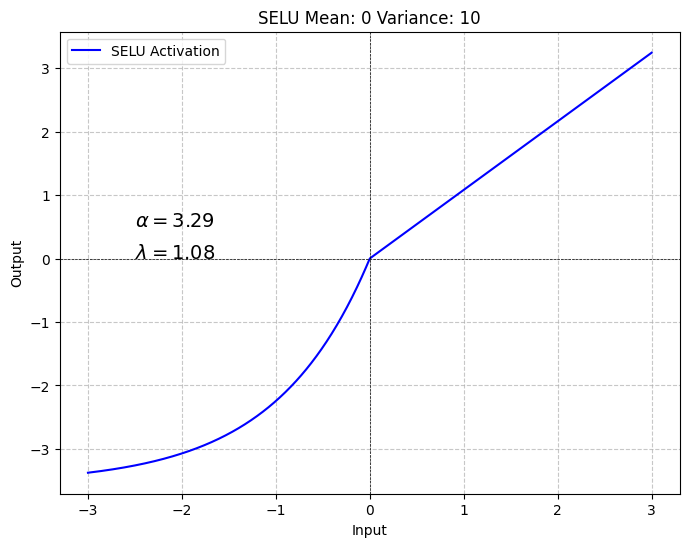

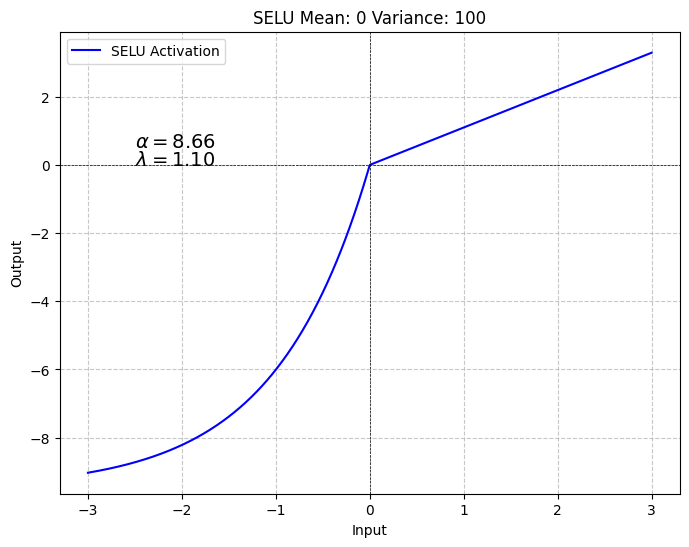

In [165]:
# plot the selu activation for different mean/variance
plot_selu(0,1)
plot_selu(0,10)
plot_selu(0,100)